# This script is used to load and process all the data images from the Inverter Data folder. It iterates over all images, and for each image, a green filter is used to determine the Watt output at a specific day. 

Selected area: x=936, y=405, width=317, height=202
Detected Green Rectangles in Selected area (x, y, height):
Location: (937, 536), Height: 13
Location: (958, 535), Height: 15
Location: (992, 522), Height: 29
Location: (1027, 511), Height: 41
Location: (1061, 515), Height: 38
Location: (1094, 479), Height: 75
Location: (1130, 492), Height: 63
Location: (1164, 521), Height: 35
Location: (1199, 538), Height: 19
Rectangle at (1199, 538) with height 19 corresponds to 25.33
Rectangle at (937, 536) with height 13 corresponds to 17.33
Rectangle at (958, 535) with height 15 corresponds to 20.00
Rectangle at (992, 522) with height 29 corresponds to 38.67
Rectangle at (1164, 521) with height 35 corresponds to 46.67
Rectangle at (1061, 515) with height 38 corresponds to 50.67
Rectangle at (1027, 511) with height 41 corresponds to 54.67
Rectangle at (1130, 492) with height 63 corresponds to 84.00
Rectangle at (1094, 479) with height 75 corresponds to 100.00

--- Merged Rectangles ---
(937, 536) | 

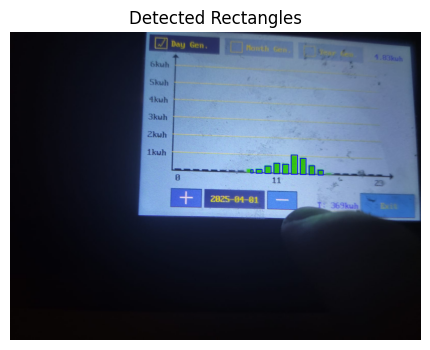

Selected area: x=857, y=453, width=511, height=300
Detected Green Rectangles in Selected area (x, y, height):
Location: (899, 701), Height: 21
Location: (938, 603), Height: 121
Location: (984, 539), Height: 187
Location: (1028, 488), Height: 241
Location: (1074, 471), Height: 259
Location: (1117, 516), Height: 217
Location: (1213, 646), Height: 87
Location: (1258, 700), Height: 33
Location: (1303, 702), Height: 31
Rectangle at (1303, 702) with height 31 corresponds to 239.38
Rectangle at (899, 701) with height 21 corresponds to 162.16
Rectangle at (1258, 700) with height 33 corresponds to 254.83
Rectangle at (1213, 646) with height 87 corresponds to 671.81
Rectangle at (938, 603) with height 121 corresponds to 934.36
Rectangle at (984, 539) with height 187 corresponds to 1444.02
Rectangle at (1117, 516) with height 217 corresponds to 1675.68
Rectangle at (1028, 488) with height 241 corresponds to 1861.00
Rectangle at (1074, 471) with height 259 corresponds to 2000.00

--- Merged Rectan

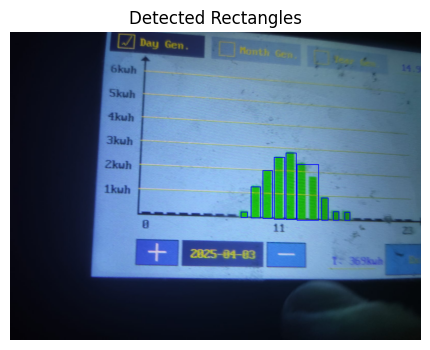

Selected area: x=764, y=375, width=488, height=289
Detected Green Rectangles in Selected area (x, y, height):
Location: (809, 627), Height: 22
Location: (852, 465), Height: 186
Location: (895, 488), Height: 164
Location: (939, 508), Height: 146
Location: (982, 535), Height: 121
Location: (1026, 471), Height: 185
Location: (1069, 401), Height: 257
Location: (1110, 469), Height: 189
Location: (1155, 525), Height: 133
Location: (1204, 608), Height: 52
Rectangle at (809, 627) with height 22 corresponds to 299.61
Rectangle at (1204, 608) with height 52 corresponds to 708.17
Rectangle at (982, 535) with height 121 corresponds to 1647.86
Rectangle at (1155, 525) with height 133 corresponds to 1811.28
Rectangle at (939, 508) with height 146 corresponds to 1988.33
Rectangle at (895, 488) with height 164 corresponds to 2233.46
Rectangle at (1026, 471) with height 185 corresponds to 2519.46
Rectangle at (1110, 469) with height 189 corresponds to 2573.93
Rectangle at (852, 465) with height 186 cor

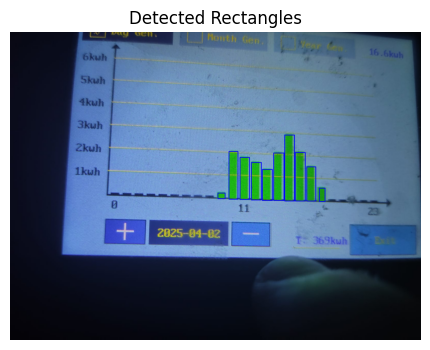

Selected area: x=0, y=0, width=0, height=0
Detected Green Rectangles in Selected area (x, y, height):


ValueError: could not convert string to float: ''

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import csv

directory = "E:\\AUB\\DDM\\Project\\Inverter Data"
output_csv = "data.csv"

# Prepare CSV header
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["filename", "x", "y", "height", "value"])

for filename in os.listdir(directory):
    if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    filepath = os.path.join(directory, filename)
    rgb_color = np.array([53, 183, 13]) 
    hsv_color = cv2.cvtColor(np.uint8([[rgb_color]]), cv2.COLOR_RGB2HSV)[0][0]

    # Load image
    img = cv2.imread(filepath)
    if img is None:
        print(f"Error loading image: {filepath}")
        continue
    scale = 1
    img = cv2.resize(img, (0, 0), fx=scale, fy=scale)
    img_copy = img.copy()

    # ROI selection
    roi_box = cv2.selectROI("Select area", img, showCrosshair=True, fromCenter=False)
    cv2.destroyWindow("Select area")
    x_roi, y_roi, w_roi, h_roi = roi_box
    print(f"Selected area: x={x_roi}, y={y_roi}, width={w_roi}, height={h_roi}")

    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_green = np.array([hsv_color[0] - 10, 100, 50])
    upper_green = np.array([hsv_color[0] + 10, 255, 255])
    mask_green = cv2.inRange(hsv_img, lower_green, upper_green)

    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([40, 255, 255])
    mask_yellow = cv2.inRange(hsv_img, lower_yellow, upper_yellow)
    mask_green_no_yellow = cv2.bitwise_and(mask_green, cv2.bitwise_not(mask_yellow))

    mask_roi = np.zeros_like(mask_green_no_yellow)
    mask_roi[y_roi:y_roi + h_roi, x_roi:x_roi + w_roi] = mask_green_no_yellow[y_roi:y_roi + h_roi, x_roi:x_roi + w_roi]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    mask_cleaned = cv2.morphologyEx(mask_roi, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rectangles = []
    max_height = 0
    for cnt in contours:
        x, y, w_box, h_box = cv2.boundingRect(cnt)
        if w_box >= 2 and h_box >= 2:
            rectangles.append((x, y, h_box))
            max_height = max(max_height, h_box)
            cv2.rectangle(img_copy, (x, y), (x + w_box, y + h_box), (255, 0, 0), 2)

    print("Detected Green Rectangles in Selected area (x, y, height):")
    for rect in sorted(rectangles):
        print(f"Location: ({rect[0]}, {rect[1]}), Height: {rect[2]}")

    max_bin_value = float(input(f"Enter the watt measured value for the highest bin in {filename}: "))
    rectangles_with_values = []
    for x, y, height in rectangles:
        value = (height / max_height) * max_bin_value
        rectangles_with_values.append((x, y, height, value))
        print(f"Rectangle at ({x}, {y}) with height {height} corresponds to {value:.2f}")

    horizontal_tolerance = 10
    rectangles_sorted = sorted(rectangles_with_values, key=lambda r: r[0])
    merged_groups = []
    if rectangles_sorted:
        current_group = [rectangles_sorted[0]]
        for rect in rectangles_sorted[1:]:
            last_x = current_group[-1][0]
            if abs(rect[0] - last_x) <= horizontal_tolerance:
                current_group.append(rect)
            else:
                merged_groups.append(current_group)
                current_group = [rect]
        merged_groups.append(current_group)

    merged_rects = []
    for group in merged_groups:
        avg_x = int(sum(r[0] for r in group) / len(group))
        avg_y = int(sum(r[1] for r in group) / len(group))
        max_height = max(r[2] for r in group)
        total_value = sum(r[3] for r in group)
        merged_rects.append((avg_x, avg_y, max_height, total_value))

    print("\n--- Merged Rectangles ---")
    for x, y, height, value in merged_rects:
        print(f"({x}, {y}) | Height: {height} | Total Value: {value:.2f}")

    # Save to CSV
    with open(output_csv, mode='a', newline='') as file:
        writer = csv.writer(file)
        for x, y, height, value in merged_rects:
            writer.writerow([filename, x, y, height, round(value, 2)])

    # Optional Visualization
    plt.figure(figsize=(12, 4))
    plt.title("Detected Rectangles")
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


# This is the step by step pipeline that we are doing on each image.

HSV of #35B70D: [ 53 237 183]
Selected area: x=482, y=312, width=731, height=403
Detected Green Rectangles in Selected area (x, y, height):
Location: (650, 663), Height: 32
Location: (695, 571), Height: 124
Location: (736, 506), Height: 191
Location: (777, 607), Height: 91
Location: (783, 448), Height: 158
Location: (819, 367), Height: 337
Location: (827, 373), Height: 235
Location: (868, 406), Height: 203
Location: (951, 474), Height: 139
Location: (997, 615), Height: 89
Location: (1036, 556), Height: 149
Location: (1084, 640), Height: 68
Location: (1130, 704), Height: 3
Location: (1137, 705), Height: 2

Computed Values for Rectangles:
Rectangle at (1137, 705) with height 2 corresponds to 18.99
Rectangle at (1130, 704) with height 3 corresponds to 28.49
Rectangle at (650, 663) with height 32 corresponds to 303.86
Rectangle at (1084, 640) with height 68 corresponds to 645.70
Rectangle at (997, 615) with height 89 corresponds to 845.10
Rectangle at (777, 607) with height 91 corresponds 

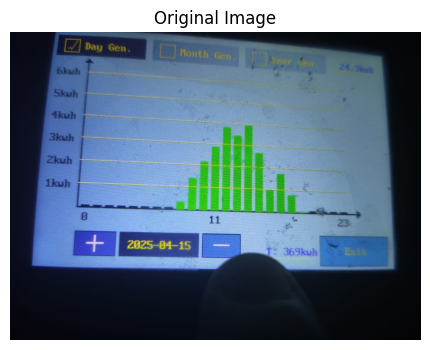

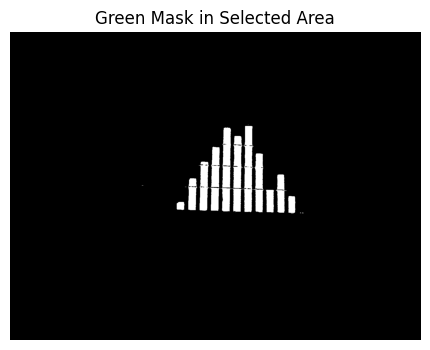

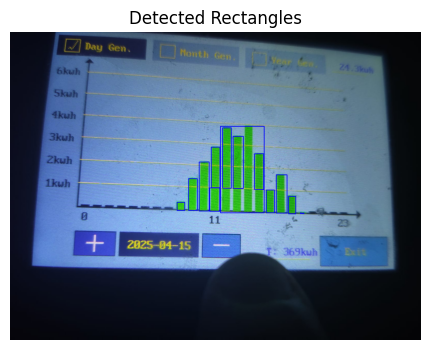

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert hex to HSV
rgb_color = np.array([53, 183, 13])  # Hex #35B70D -> RGB
hsv_color = cv2.cvtColor(np.uint8([[rgb_color]]), cv2.COLOR_RGB2HSV)[0][0]
print(f"HSV of #35B70D: {hsv_color}")

# Load and resize image
img = cv2.imread(r"E:\AUB\DDM\Project\Inverter Data\WhatsApp Image 2025-05-04 at 10.55.51 AM (2).jpeg")
scale = 1
img = cv2.resize(img, (0, 0), fx=scale, fy=scale)
h, w = img.shape[:2]
img_copy = img.copy()

# Select ROI
roi_box = cv2.selectROI("Select area", img, showCrosshair=True, fromCenter=False)
cv2.destroyWindow("Select area")
x_roi, y_roi, w_roi, h_roi = roi_box
print(f"Selected area: x={x_roi}, y={y_roi}, width={w_roi}, height={h_roi}")

# Convert to HSV
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Green mask
lower_green = np.array([hsv_color[0] - 10, 100, 50])
upper_green = np.array([hsv_color[0] + 10, 255, 255])
mask_green = cv2.inRange(hsv_img, lower_green, upper_green)

# Yellow exclusion
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([40, 255, 255])
mask_yellow = cv2.inRange(hsv_img, lower_yellow, upper_yellow)
mask_green_no_yellow = cv2.bitwise_and(mask_green, cv2.bitwise_not(mask_yellow))

# Apply ROI
mask_roi = np.zeros_like(mask_green_no_yellow)
mask_roi[y_roi:y_roi + h_roi, x_roi:x_roi + w_roi] = mask_green_no_yellow[y_roi:y_roi + h_roi, x_roi:x_roi + w_roi]

# Morphology
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
mask_cleaned = cv2.morphologyEx(mask_roi, cv2.MORPH_CLOSE, kernel)

# Find contours
contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Extract rectangles
min_width = 2
min_height = 2
rectangles = []
max_height = 0

for cnt in contours:
    x, y, w_box, h_box = cv2.boundingRect(cnt)
    if w_box >= min_width and h_box >= min_height:
        rectangles.append((x, y, h_box))
        max_height = max(max_height, h_box)
        cv2.rectangle(img_copy, (x, y), (x + w_box, y + h_box), (255, 0, 0), 2)

# Print detected rectangles
print("Detected Green Rectangles in Selected area (x, y, height):")
for rect in sorted(rectangles):
    print(f"Location: ({rect[0]}, {rect[1]}), Height: {rect[2]}")

# Input max bin value
max_bin_value = float(input("Enter the watt measured value for the highest bin: "))

# Compute raw values
rectangles_with_values = []
print("\nComputed Values for Rectangles:")
for x, y, height in rectangles:
    value = (height / max_height) * max_bin_value
    rectangles_with_values.append((x, y, height, value))
    print(f"Rectangle at ({x}, {y}) with height {height} corresponds to {value:.2f}")

# Group and merge horizontally aligned rectangles
horizontal_tolerance = 10
rectangles_sorted = sorted(rectangles_with_values, key=lambda r: r[0])
merged_groups = []
current_group = [rectangles_sorted[0]]

for rect in rectangles_sorted[1:]:
    last_x = current_group[-1][0]
    if abs(rect[0] - last_x) <= horizontal_tolerance:
        current_group.append(rect)
    else:
        merged_groups.append(current_group)
        current_group = [rect]
merged_groups.append(current_group)

# Merge each group
merged_rects = []
for group in merged_groups:
    avg_x = int(sum(r[0] for r in group) / len(group))
    avg_y = int(sum(r[1] for r in group) / len(group))
    max_height = max(r[2] for r in group)
    total_value = sum(r[3] for r in group)
    merged_rects.append((avg_x, avg_y, max_height, total_value))

# Print merged results
print("\n--- Merged Rectangles ---")
for x, y, height, value in merged_rects:
    print(f"({x}, {y}) | Height: {height} | Total Value: {value:.2f}")

# --- Visualization ---
plt.figure(figsize=(12, 4))
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.figure(figsize=(12, 4))
plt.title("Green Mask in Selected Area")
plt.imshow(mask_roi, cmap='gray')
plt.axis("off")

plt.figure(figsize=(12, 4))
plt.title("Detected Rectangles")
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
